# B-Cubed DEMO BioSpace25
## Building data cubes



### Install missing packages

In [ ]:
%pip install pygbif
%pip install dask
%pip install geopandas
%pip install netCDF4
%pip install rioxarray
%pip install cartopy
%pip install basemap
%pip install xarray-spatial

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

### Loading packages

In [ ]:
from pygbif import occurrences as occ
import pandas as pd
import geopandas as gpd
from pyproj import Proj, Transformer
from shapely.geometry import mapping
from shapely.geometry import Polygon
import matplotlib.pyplot as plt


import io
from io import StringIO
import zipfile
import math
from rioxarray.rioxarray import _make_coords
from rasterio.vrt import WarpedVRT

import xrspatial.multispectral as ms

import contextily as ctx
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import rioxarray
import planetary_computer
import affine
import rasterio  # Import rasterio!
import stackstac

/home/maarten/.local/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Loading Earth Engine

### Example of the GBIF API through pygbif

In [2]:
from pygbif import occurrences
data = occurrences.search(speciesKey=5229490, limit=10)

print(data['results'])

[{'key': 5011069995, 'datasetKey': 'ba19fc1d-670c-426b-b99d-49f003792ac4', 'publishingOrgKey': 'f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc', 'installationKey': 'd973e647-8f5f-4e6e-a1c6-65930deb0590', 'hostingOrganizationKey': 'f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc', 'publishingCountry': 'RU', 'protocol': 'DWC_ARCHIVE', 'lastCrawled': '2025-01-22T20:14:44.646+00:00', 'lastParsed': '2025-02-02T05:15:02.380+00:00', 'crawlId': 303, 'projectId': 'N-Eurasia-Russia2021', 'programmeAcronym': 'N-Eurasia', 'extensions': {}, 'basisOfRecord': 'MACHINE_OBSERVATION', 'individualCount': 1, 'occurrenceStatus': 'PRESENT', 'taxonKey': 5229490, 'kingdomKey': 1, 'phylumKey': 44, 'classKey': 212, 'orderKey': 729, 'familyKey': 5235, 'genusKey': 7237083, 'speciesKey': 5229490, 'acceptedTaxonKey': 5229490, 'scientificName': 'Pica pica (Linnaeus, 1758)', 'acceptedScientificName': 'Pica pica (Linnaeus, 1758)', 'kingdom': 'Animalia', 'phylum': 'Chordata', 'order': 'Passeriformes', 'family': 'Corvidae', 'genus': 'Pica',

## GBIF data Cubes

### Generating the Cube

#### Exemplar JSON query for generating a data cube


```
# DON'T EXECUTE THIS CELL. FOR DEMO PUPOSE ONLY #
{
  "sendNotification": true,
  "notificationAddresses": [
    "maarten.trekels@plantentuinmeise.be"
  ],
  "format": "SQL_TSV_ZIP",
  "sql": "SELECT  PRINTF('%04d-%02d', \"year\", \"month\") AS yearMonth,
   GBIF_EEARGCode(10000, decimalLatitude,  decimalLongitude,  COALESCE(coordinateUncertaintyInMeters, 1000) ) AS eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway,
   COUNT(*) AS occurrences,
   COUNT(DISTINCT recordedBy) AS distinctObservers
   FROM  occurrence
   WHERE occurrenceStatus = 'PRESENT'
   AND countryCode = 'BE'
   AND hasCoordinate = TRUE
   AND NOT ARRAY_CONTAINS(issue, 'ZERO_COORDINATE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_OUT_OF_RANGE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_INVALID')
   AND NOT ARRAY_CONTAINS(issue, 'COUNTRY_COORDINATE_MISMATCH')
   AND \"month\" IS NOT NULL
   GROUP BY yearMonth,
   eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway
   ORDER BY  yearMonth DESC,
   eeaCellCode ASC,
   speciesKey ASC"
}


```



## Loading the Data cube in pandas



You can download a pre generated data cube from GitHub or any other online resource

#### Get data from Drive

In [ ]:
def convert_to_int(x):
       try:
           return int(x)
       except ValueError:
           return pd.NA  # or np.nan if you prefer NumPy NaNs

data = pd.read_csv('./data/Cube_ZA_QDGC_l3.csv', sep='\t', converters={'familykey': convert_to_int, 'specieskey': convert_to_int})

data['familykey'] = pd.to_numeric(data['familykey'], errors='coerce').astype('Int64')
data['specieskey'] = pd.to_numeric(data['specieskey'], errors='coerce').astype('Int64')


In [5]:
print(data)

         yearmonth    qdgccode  familykey        family  specieskey  \
0          2024-09  E016S28ADD       2406  Crassulaceae     7716880   
1          2024-09  E016S28BCC       2406  Crassulaceae     7716880   
2          2024-09  E016S28BDD       4676   Geraniaceae     3826148   
3          2024-09  E016S28BDD       2406  Crassulaceae     7334236   
4          2024-09  E016S28CBB       6752     Aizoaceae     8003531   
...            ...         ...        ...           ...         ...   
17876161   1772-04  E025S28CCC       7689   Orchidaceae     2783834   
17876162   1694-10  E027S32DBB       2430    Onagraceae     3188875   
17876163   1678-02  E028S25DCB       7359     Araneidae        <NA>   
17876164   1645-12  E030S30BBC       7016  Notodontidae     1824935   
17876165   1608-10  E023S33ABC       4334        Apidae     5040145   

                             species  occurrences  familycount  
0                  Crassula sladenii            1      44434.0  
1                

## Getting a Geopackage file from the Grid that you use

In [ ]:
# Load QDGC code

input_file = "./data/qdgc_south_africa.gpkg"

qdgc_ref = gpd.read_file(input_file, layer='tbl_qdgc_03')

In [ ]:
print(qdgc_ref)

## Merging the Data cube with the grid

In [10]:
test_merge = pd.merge(data, qdgc_ref, left_on='qdgccode', right_on='qdgc')

In [11]:
# Convert to GeoDataFrame

gdf = gpd.GeoDataFrame(test_merge, geometry='geometry')

gdf = gdf.set_crs(epsg=4326, inplace=False)

## Filtering data (e.g. on species)
Check for a single species (Loxodonta africana: https://www.gbif.org/species/2435350)

In [12]:
filtered_gdf = gdf[gdf['specieskey'].eq(2435350)]
filtered_gdf = filtered_gdf[filtered_gdf['yearmonth'].str.contains('2023')]

print(filtered_gdf)


       yearmonth    qdgccode  familykey        family  specieskey  \
184888   2023-12  E019S33BBA       9427  Elephantidae     2435350   
190432   2023-12  E021S34BAB       9427  Elephantidae     2435350   
196545   2023-12  E025S33BAD       9427  Elephantidae     2435350   
196547   2023-12  E025S33BBC       9427  Elephantidae     2435350   
196550   2023-12  E025S33BCB       9427  Elephantidae     2435350   
...          ...         ...        ...           ...         ...   
857526   2023-01  E031S25ADD       9427  Elephantidae     2435350   
858242   2023-01  E031S25BBB       9427  Elephantidae     2435350   
858597   2023-01  E031S25BBD       9427  Elephantidae     2435350   
863794   2023-01  E032S24ACA       9427  Elephantidae     2435350   
866234   2023-01  E032S28ABB       9427  Elephantidae     2435350   

                   species  occurrences  familycount        qdgc  level_qdgc  \
184888  Loxodonta africana            1       5301.0  E019S33BBA           3   
190432  Lox

In [13]:
# Free up some RAM

del gdf
del test_merge
del data

## Visualization of the data cubes on a map with different layers

### Plotting the data on OpenStreetMap

Choosing S2A_MSIL2A_20220513T073621_R092_T36KUV_20220515T130938 from 2022-05-13 with 0.0% cloud cover


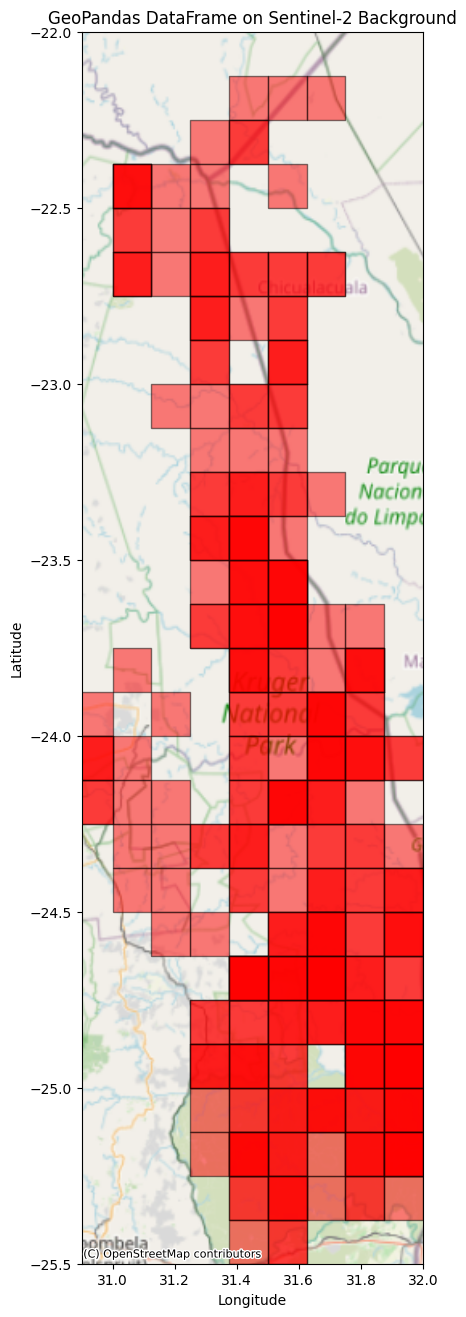

In [ ]:


bbox_total = filtered_gdf.total_bounds
bbox = [30.9, -25.5, 32.0, -22.0] #Kruger bbox

aoi = {
    "type": "Polygon",
    "coordinates": [[
        [bbox[0], bbox[1]],
        [bbox[2], bbox[1]],
        [bbox[2], bbox[3]],
        [bbox[0], bbox[3]],
        [bbox[0], bbox[1]],
    ]],
}




# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))


# Plot the GeoDataFrame
filtered_gdf.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.5)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:4326")


# Labels and Title
plt.title("GeoPandas DataFrame on OpenStreetMap Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

### Getting Sentinel-2 image from Microsoft Planetary Computer

In [ ]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)


items = catalog.search(
    bbox=bbox,
    datetime="2013-06-01/2022-05-14",  # Adjust date range as needed 11/18/2024 05/13/2022 
    query={"eo:cloud_cover": {"lt": 10}},  # Adjust cloud cover as needed
    collections=["sentinel-2-l2a"],
).items()

least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

scene_data = (
    stackstac.stack(
        [least_cloudy_item.to_dict()],
        epsg=4326,
        resampling=rasterio.enums.Resampling.bilinear,
        resolution=0.001,  # resolution in the output CRS’s units
        assets=["B04", "B03", "B02"],  # red, green, blue bands
        chunksize=2048,
    )
    .isel(time=0)
    .persist()
)

scene_data

<xarray.DataArray 'stackstac-966d939ba316d852fcf0d3903aedfd1b' (band: 3,
                                                                y: 1002, x: 1083)> Size: 26MB
dask.array<getitem, shape=(3, 1002, 1083), dtype=float64, chunksize=(1, 1002, 1083), chunktype=numpy.ndarray>
Coordinates: (12/46)
    time                                     datetime64[ns] 8B 2022-05-13T07:...
    id                                       <U54 216B 'S2A_MSIL2A_20220513T0...
  * band                                     (band) <U3 36B 'B04' 'B03' 'B02'
  * x                                        (x) float64 9kB 31.04 ... 32.12
  * y                                        (y) float64 8kB -22.59 ... -23.59
    s2:granule_id                            <U62 248B 'S2A_OPER_MSI_L2A_TL_E...
    ...                                       ...
    proj:bbox                                object 8B {300000.0, 7500040.0, ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(31.04, -23.596, 32.123, -22.59...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 31.04|\n| 0.00,-0.00,-22.59|\n| 0.00, 0.00, 1.00|
    resolution:  0.001

### Overlaying Cube With Sentinel data

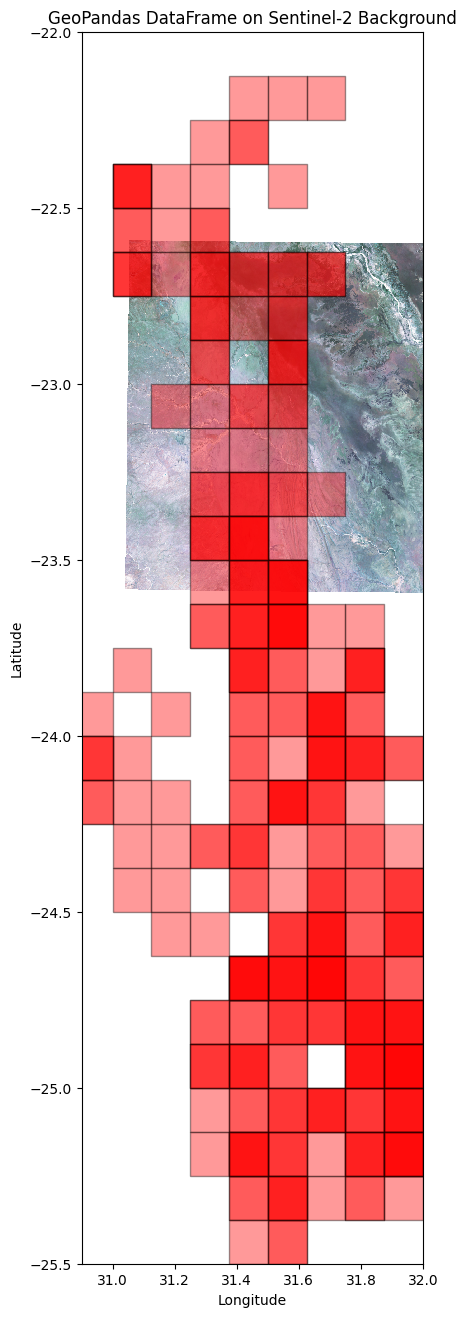

In [35]:
import matplotlib.pyplot as plt
import xrspatial.multispectral as ms

#... (your code to generate scene_data and filtered_gdf)

# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))

# Create the true-color image
sentinel_img = ms.true_color(*scene_data)  # No need for name="epsg=4326" here

# Plot the Sentinel-2 image on the existing axes
sentinel_img.plot.imshow(ax=ax, add_colorbar=False)  # Plot on 'ax', remove extra colorbar

# Plot the GeoDataFrame on the same axes
filtered_gdf.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.4)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

# Labels and Title
plt.title("GeoPandas DataFrame on Sentinel-2 Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

## Export the data to GeoParquet

In [ ]:
#gdf.to_parquet('/content/drive/Shareddrives/BioSpace25/supporting_data/data_ZA.parquet')

# EBV data cubes in NetCDF format

In [ ]:
import netCDF4 as nc
import xarray as xr


birds_file = xr.open_dataset('./data/viti_spepop_id77_20240206_v1.nc')

print(birds_file)

<xarray.Dataset> Size: 26kB
Dimensions:  (lon: 559, lat: 437, time: 1, entity: 486)
Coordinates:
  * lon      (lon) float64 4kB 9.45e+05 9.55e+05 ... 6.515e+06 6.525e+06
  * lat      (lat) float64 3kB 5.305e+06 5.295e+06 ... 9.55e+05 9.45e+05
  * time     (time) datetime64[ns] 8B 2018-01-01
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Data variables:
    crs      |S1 1B ...
Attributes: (12/38)
    Conventions:                CF-1.8, ACDD-1.3, EBV-1.0
    naming_authority:           The German Centre for Integrative Biodiversit...
    history:                    EBV netCDF created using ebvcube, 2024-02-06
    ebv_vocabulary:             https://portal.geobon.org/api/v1/ebv
    ebv_cube_dimensions:        lon, lat, time, entity
    keywords:                   ebv_class: Species populations, ebv_name: Spe...
    ...                         ...
    geospatial_lat_units:       meter
    time_coverage_start:        2013-01-01
    time_coverage_end:       

In [ ]:
def print_netcdf_structure(nc_file_path):
  """Prints the structure (groups, variables, and their paths) of a NetCDF file.

  Args:
    nc_file_path: Path to the NetCDF file.
  """
  def print_group_structure(group, path=""):
    """Recursively prints the structure of a group within the NetCDF file."""
    for var_name in group.variables:
      print(f"{path}/{var_name}")  # Print variable path
    for group_name in group.groups:
      subgroup = group.groups[group_name]
      print_group_structure(subgroup, f"{path}/{group_name}")  # Recursively explore subgroups

  with nc.Dataset(nc_file_path, 'r') as nc_file:
    print_group_structure(nc_file)  # Start with the root group

# Example usage:
nc_file_path = './data/viti_spepop_id77_20240206_v1.nc'
print_netcdf_structure(nc_file_path)

/lon
/lat
/time
/crs
/entity
/metric_1/ebv_cube


In [7]:
print(birds_file.variables)

Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 559)> Size: 4kB
array([ 945000.,  955000.,  965000., ..., 6505000., 6515000., 6525000.])
Attributes:
    long_name:      lon
    standard_name:  projection_x_coordinate
    axis:           X
    units:          meter, 'lat': <xarray.IndexVariable 'lat' (lat: 437)> Size: 3kB
array([5305000., 5295000., 5285000., ...,  965000.,  955000.,  945000.])
Attributes:
    long_name:      lat
    standard_name:  projection_y_coordinate
    axis:           Y
    units:          meter, 'time': <xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T, 'crs': <xarray.Variable ()> Size: 1B
[1 values with dtype=|S1]
Attributes:
    spatial_ref:                     PROJCRS["ETRS89-extended / LAEA Europe",...
    GeoTransform:                    940000 10000 0.0 5310000 0.0 -10000
    grid_mapping_name:               lambert_azimuthal_equal_area
    l

In [8]:
time = birds_file.variables['time']
print(time)

print(birds_file['entity'])

<xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T
<xarray.DataArray 'entity' (entity: 486)> Size: 18kB
array([b'Gavia stellata                       ',
       b'Gavia arctica                        ',
       b'Tachybaptus ruficollis               ', ...,
       b'Accipiter gentilis all others        ',
       b'Melanitta nigra s. str.              ',
       b'Sylvia subalpina                     '], dtype='|S37')
Coordinates:
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Attributes:
    units:                           1
    ebv_entity_type:                 Species
    ebv_entity_scope:                Bird species listed under the Art. 12 of...
    ebv_entity_classification_name:  Species names as accepted by the Birds D...
    ebv_entity_classification_url:   https://cdr.eionet.europa.eu/help/birds_...
    long_name:                     

/home/maarten/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/maarten/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


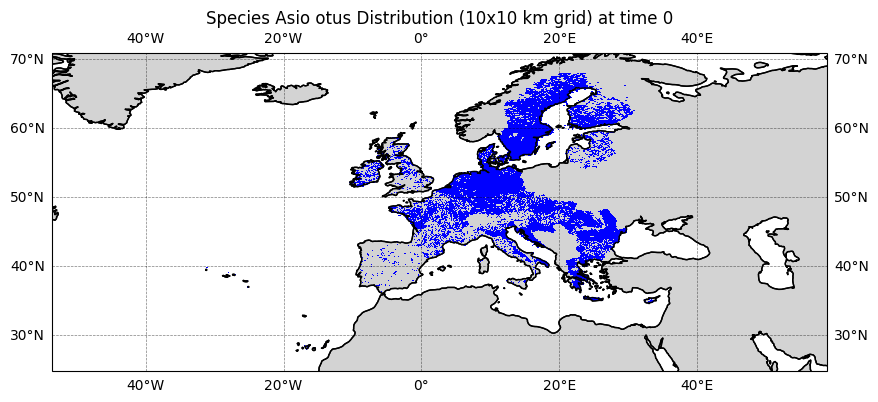

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from pyproj import Transformer
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Load Dataset Efficiently ---
birds_file = xr.open_dataset(
    './data/viti_spepop_id77_20240206_v1.nc',
    group="metric_1",
    chunks={'entity': 1, 'time': 1}  # Load only one entity/time slice at a time
)

# --- Select Target Species and Time ---
species_index = 150  # Change to the species index you need
time_index = 0  # Change to the desired time index

# Extract only the required slice
species_data_subset = birds_file['ebv_cube'].sel(entity=species_index, time=time_index).compute()

# Convert to a 2D array
species_distribution_2d = np.squeeze(species_data_subset)

# --- Load Longitude and Latitude (Only Once) ---
with xr.open_dataset('./data/viti_spepop_id77_20240206_v1.nc') as ds:
    lon = ds['lon'].values  # 1D array (size: 559)
    lat = ds['lat'].values  # 1D array (size: 437)

# --- Create Meshgrid Efficiently ---
lon_grid, lat_grid = np.meshgrid(lon, lat)

# --- Efficient Coordinate Transformation ---
transformer = Transformer.from_crs("epsg:3035", "epsg:4326", always_xy=True)

# Transform the entire 2D meshgrid
lon_deg, lat_deg = transformer.transform(lon_grid, lat_grid)

# --- Create the Plot ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# --- 🔹 Fix: Use Discrete Colormap Without Color Bar ---
unique_values = np.unique(species_distribution_2d)

# If only one value, choose a single solid color
if len(unique_values) == 1:
    cmap = ListedColormap(["red"])  # Single-color for uniform data
    norm = None
else:
    cmap = ListedColormap(["white", "blue"])  # Adjust colors as needed
    norm = BoundaryNorm([0, 0.5, 1], cmap.N)

# --- 🔹 Fix: Use `shading="nearest"` to Ensure Correct Grid Alignment ---
cs = ax.pcolormesh(
    lon_deg, lat_deg, species_distribution_2d,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    shading='nearest'  # Prevents visual distortion
)

# --- 🔹 Completely Remove Color Bar ---
# No `fig.colorbar(cs)`, so no scale bar will be shown

# --- Get the Species Name Efficiently ---
with xr.open_dataset('./data/viti_spepop_id77_20240206_v1.nc') as ds:
    species_name = ds['entity'].values[species_index].decode('utf-8').strip()

# --- Final Plot Customization ---
ax.set_title(f"Species {species_name} Distribution (10x10 km grid) at time {birds_file['time'].values[time_index].item()}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# --- 🔹 Fix: Add Grid Lines to Show Exact 10x10 km Cells ---
gridlines = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Show the plot
plt.show()
